In [1]:
from scGeneFit.functions import *

%matplotlib inline
import numpy as np
np.random.seed(0) 

In [2]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

# ML

# ISSUE:
* imputer seperation between train and test
* train test split in run_scgenefit and run_oneVSall

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time


from sklearn.impute import SimpleImputer
tcga = pd.read_csv('../../../data/My_own_project/TCGA_ready_monod2_intersectedSortedMerged_std_filtered_cpg5_std0.1_sorted_Allmatrix',sep='\t')

Replicate_Threshold =  150
Exclude_Targets = ['Kidney_TCGA-KIRP_Primary_Tumor','Kidney_TCGA-KIRC_Solid_Tissue_Normal']
print(tcga.shape)
tcga.head()

(2744, 10593)


,feature,Corpus_uteri_TCGA-UCEC_Primary_Tumor_8597f800-a2b5-43ce-b3f3-daa8c7048e13.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_cd70ed89-aad8-4e29-a71f-290a823471cf.methylation_array.sesame.level3betas.txt_WGBS,"Uterus,_NOS_TCGA-SARC_Primary_Tumor_c719a19b-5420-45f8-a023-9a2cc7fa94fe.methylation_array.sesame.level3betas.txt_WGBS",Palate_TCGA-HNSC_Primary_Tumor_aedf9a79-221f-4195-a962-db92372d097b.methylation_array.sesame.level3betas.txt_WGBS,Skin_TCGA-SKCM_Metastatic_a13db7a8-f424-4ef3-8359-5071991079e4.methylation_array.sesame.level3betas.txt_WGBS,Kidney_TCGA-KIRC_Solid_Tissue_Normal_0f48d8af-223f-4c00-9b13-540614d35bbc.methylation_array.sesame.level3betas.txt_WGBS,"Bones,_joints_and_articular_cartilage_of_other_and_unspecified_sites_TARGET-OS_Primary_Tumor_409b8601-71e2-4729-ab56-88ca4e1005a0.methylation_array.sesame.level3betas.txt_WGBS",Breast_TCGA-BRCA_Primary_Tumor_f089abf9-4cbc-407c-9207-439410f6d0a2.methylation_array.sesame.level3betas.txt_WGBS,Bladder_TCGA-BLCA_Primary_Tumor_06a77641-690f-4839-8ba0-e20f3d6fcc63.methylation_array.sesame.level3betas.txt_WGBS,...,"Uterus,_NOS_TCGA-UCS_Primary_Tumor_81bbea05-274f-435f-b547-19d4b3c152a2.methylation_array.sesame.level3betas.txt_WGBS",Hematopoietic_and_reticuloendothelial_systems_TARGET-AML_Bone_Marrow_Normal_b54bc046-87d2-431b-82b4-ad8694521851.methylation_array.sesame.level3betas.txt_WGBS,Breast_TCGA-BRCA_Primary_Tumor_c8e84511-71ce-4938-a374-99980bf6d7ba.methylation_array.sesame.level3betas.txt_WGBS,Cervix_uteri_TCGA-CESC_Primary_Tumor_01d86436-a861-4e72-bd5a-0ac0df35e4c0.methylation_array.sesame.level3betas.txt_WGBS,Cervix_uteri_TCGA-CESC_Primary_Tumor_4f9b862c-40f7-49ee-a68a-64504793a165.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_73298c7a-eff4-419f-a6f0-db31e208bf86.methylation_array.sesame.level3betas.txt_WGBS,Liver_and_intrahepatic_bile_ducts_TCGA-LIHC_Primary_Tumor_b16838f8-aff7-46e0-b030-3e452de748ba.methylation_array.sesame.level3betas.txt_WGBS,Corpus_uteri_TCGA-UCEC_Primary_Tumor_fe4ba5ac-1b7c-4913-a5a7-ff52d7707228.methylation_array.sesame.level3betas.txt_WGBS,Other_and_unspecified_parts_of_tongue_TCGA-HNSC_Primary_Tumor_56917a7d-9506-4165-b3a0-4f6063a5b508.methylation_array.sesame.level3betas.txt_WGBS,Bronchus_and_lung_TCGA-LUAD_Primary_Tumor_97db6454-78f6-4fb5-a488-5726522a7a7e.methylation_array.sesame.level3betas.txt_WGBS
0,chr10:100186139-100186254,0.041399,0.038079,0.042326,0.046239,0.043101,0.033680,0.040959,0.045317,0.045673,...,0.055478,0.042686,0.041410,0.039225,0.043447,0.058949,0.042591,0.041167,0.036830,0.037224
1,chr10:100229578-100229629,0.022317,0.018440,0.020859,0.018548,0.017185,0.018486,0.017680,0.018442,0.021058,...,0.024121,0.026927,0.018745,0.020033,0.023509,0.025678,0.028646,0.020030,0.024021,0.021566
2,chr10:100267670-100267870,0.035731,0.029624,0.029011,0.030375,0.028980,0.025504,0.033089,0.035994,0.029622,...,0.037764,0.031092,0.032122,0.036240,0.027703,0.037718,0.031346,0.043094,0.029956,0.025594
3,chr10:100286668-100286790,0.028009,0.036294,0.036452,0.033784,0.032713,0.029189,0.035594,0.037943,0.037887,...,0.038742,0.044145,0.033512,0.035239,0.039662,0.036926,0.035213,0.031359,0.029846,0.032740
4,chr10:100987280-100987660,0.019472,0.022886,0.023690,0.022559,0.023197,0.019916,0.023040,0.024651,0.024324,...,0.026392,0.026318,0.023245,0.025501,0.028305,0.027543,0.022978,0.025109,0.020021,0.022781


In [4]:
#### IMPUTATION should be seperately done
def train_test(input_df, threshold, exclude_targets=None, handle_nan='mean'):
    # Transpose the DataFrame
    df_transposed = input_df.T
    # Remove the first row
    df_transposed = df_transposed.drop(df_transposed.index[0])
    
    # Handle NaN values according to the specified strategy
    if handle_nan == 'mean':
        imputer = SimpleImputer(strategy='mean')
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'median':
        imputer = SimpleImputer(strategy='median')
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'constant':
        imputer = SimpleImputer(strategy='constant', fill_value=-1)
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'remove':
        df_transposed.dropna(inplace=True)
    
    # List of substrings to search for
    substrings = ['_Tumor', 'Metastatic', '_Normal', '_Cancer']
    
    # Function to create a target value based on the index, by cutting off everything after the specified substrings
    def create_target(index):
        for substring in substrings:
            pos = index.find(substring)
            if pos != -1:
                # Cut off everything after the substring, but include the substring itself
                return index[:pos + len(substring)]
        # If no substring is found, return the index as is
        return index
    
    # Apply the function to each index to create the Target column
    df_transposed['Target'] = [create_target(index) for index in df_transposed.index]
    
    # Encode the 'Target' column, starting with 1
    df_transposed['Target_encoded'] = pd.factorize(df_transposed['Target'])[0] + 1
    
    # Calculate the frequency of each value in the 'Target' column
    value_counts = df_transposed['Target'].value_counts()
    
    # Determine which values meet or exceed the threshold
    values_to_keep = value_counts[value_counts >= threshold].index
    
    # Filter the DataFrame to only include rows with 'Target' values meeting/exceeding the threshold
    df_filtered = df_transposed[df_transposed['Target'].isin(values_to_keep)]
    
    # If exclude_targets is provided, remove rows with 'Target' values in exclude_targets
    if exclude_targets is not None:
        df_filtered = df_filtered[~df_filtered['Target'].isin(exclude_targets)]
    
    # Print information about the target values that pass the threshold
    print("Target values that pass the threshold:", values_to_keep.tolist())
    print("Total number of unique target values that pass the threshold:", len(values_to_keep))
    
    # Print the number of unique targets after excluding specific targets (if any)
    unique_targets_after_exclusion = df_filtered['Target'].nunique()
    print("Number of unique targets after exclusion:", unique_targets_after_exclusion)


    print(df_filtered.shape)


    X_train, X_test, y_train, y_test = train_test_split(
            df_filtered.drop(columns=['Target']), # Features (all columns except 'Target')
            df_filtered['Target'],                # Target variable
            test_size=0.2,                        # Size of the testing set, e.g., 20%
            random_state=0,                      # Seed for random number generator for reproducibility
            stratify=df_filtered['Target']        # Stratify based on the 'Target' column
        )
    return X_train, X_test, y_train, y_test


# first run train_test
def data_for_scgenefit (df_filtered, df_target):
    # Separate the DataFrame into features, Target_encoded, and Target
    features = df_filtered.drop(['Target_encoded'], axis=1).to_numpy()
    target_encoded = df_filtered['Target_encoded'].to_numpy()
    target = df_target.tolist()
    
    # Return the features as a NumPy array, Target_encoded as a NumPy array, and Target as a list
    return features, target_encoded, target




In [5]:
X_train, X_test, y_train, y_test = train_test( tcga, Replicate_Threshold, exclude_targets = Exclude_Targets)
print(tcga.shape)
print(X_train.shape)
print(X_test.shape)

Target values that pass the threshold: ['Breast_TCGA-BRCA_Primary_Tumor', 'Brain_TCGA-LGG_Primary_Tumor', 'Thyroid_gland_TCGA-THCA_Primary_Tumor', 'Prostate_gland_TCGA-PRAD_Primary_Tumor', 'Bronchus_and_lung_TCGA-LUAD_Primary_Tumor', 'Corpus_uteri_TCGA-UCEC_Primary_Tumor', 'Bladder_TCGA-BLCA_Primary_Tumor', 'Stomach_TCGA-STAD_Primary_Tumor', 'Liver_and_intrahepatic_bile_ducts_TCGA-LIHC_Primary_Tumor', 'Bronchus_and_lung_TCGA-LUSC_Primary_Tumor', 'Skin_TCGA-SKCM_Metastatic', 'Kidney_TCGA-KIRC_Primary_Tumor', 'Colon_TCGA-COAD_Primary_Tumor', 'Cervix_uteri_TCGA-CESC_Primary_Tumor', 'Kidney_TCGA-KIRP_Primary_Tumor', 'Hematopoietic_and_reticuloendothelial_systems_TCGA-LAML_Primary_Blood_Derived_Cancer', 'Pancreas_TCGA-PAAD_Primary_Tumor', 'Esophagus_TCGA-ESCA_Primary_Tumor', 'Kidney_TCGA-KIRC_Solid_Tissue_Normal', 'Testis_TCGA-TGCT_Primary_Tumor']
Total number of unique target values that pass the threshold: 20
Number of unique targets after exclusion: 18
(6806, 2746)
(2744, 10593)
(5444, 2

In [6]:
def run_scgenefit(numpy_data,numpy_data_target, num_markers = 50):
    [data, labels, names] = data_for_scgenefit(numpy_data,numpy_data_target)

    N,d=data.shape
    
    method='centers'
    redundancy=0.25

    start_time = time.time() # Record the start time
    markers= get_markers(data, labels, num_markers, method=method, redundancy=redundancy)
    end_time = time.time() # Record the end time
    print(f"Execution time: {end_time - start_time} seconds")
    
    accuracy=performance(data, labels, data, labels, clf)
    accuracy_markers=performance(data[:,markers], labels, data[:,markers], labels, clf)
    
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

    #TSNE plot
    a=plot_marker_selection(data, markers, names)

    return markers

In [7]:
def run_oneVSall (numpy_data,numpy_data_target, num_markers = 50):
    [data, labels, names] = data_for_scgenefit(numpy_data, numpy_data_target)

    N,d=data.shape

    start_time = time.time() # Record the start time
    markers2=one_vs_all_selection(data,labels)
    end_time = time.time() # Record the end time
    print(f"Execution time: {end_time - start_time} seconds")

    accuracy=performance(data, labels, data, labels, clf)
    accuracy_markers=performance(data[:,markers2], labels, data[:,markers2], labels, clf)
    
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
    a=plot_marker_selection(data, markers2, names)
    return markers2

Solving a linear program with 2744 variables and 83 constraints
Time elapsed: 0.5665650367736816 seconds
Execution time: 0.5690329074859619 seconds
Accuracy (whole data, 2744  markers):  0.770940484937546
Accuracy (selected 50 markers) 0.727773695811903
Computing TSNE embedding
Elapsed time: 32.437471866607666 seconds


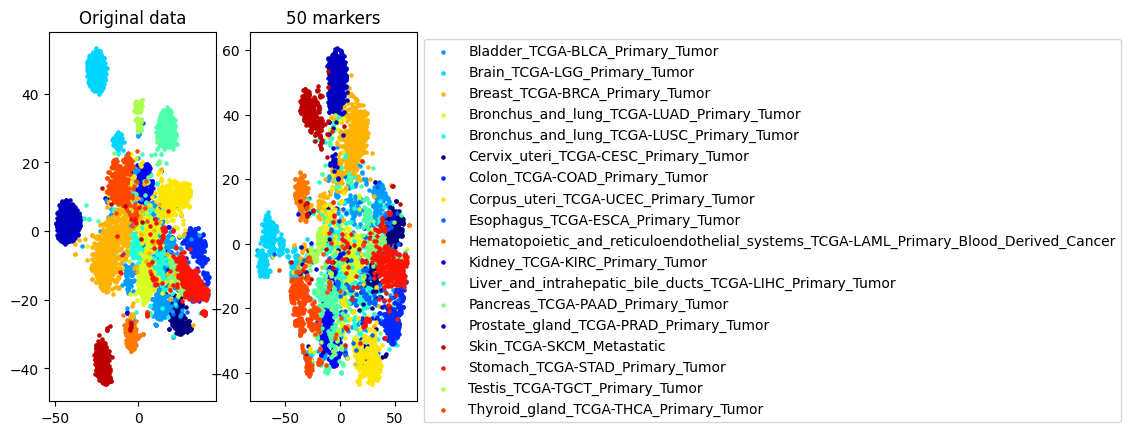

In [8]:
scMarkers = run_scgenefit(X_train,y_train)

Execution time: 163.44779300689697 seconds
Accuracy (whole data, 2744  markers):  0.770940484937546
Accuracy (selected 50 markers) 0.6610947832476121
Computing TSNE embedding
Elapsed time: 30.244643688201904 seconds


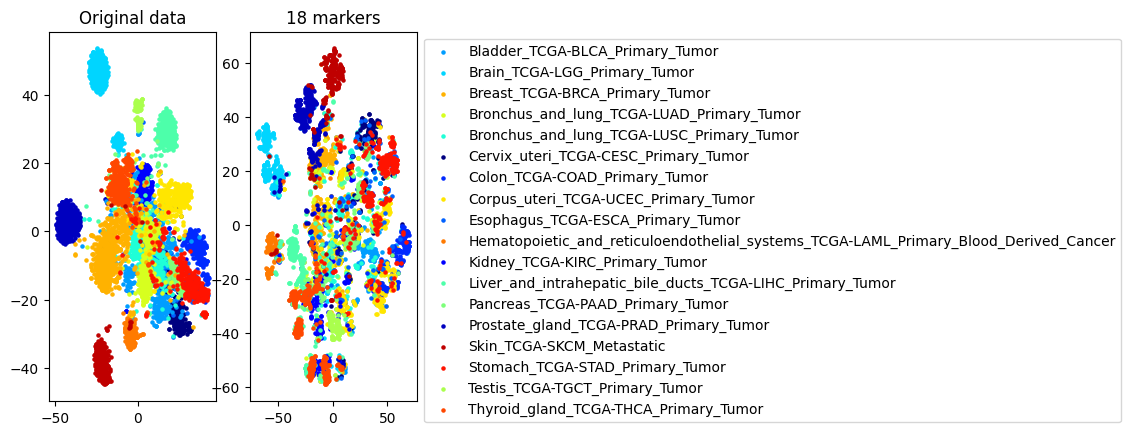

In [9]:
one_vs_all_Markers = run_oneVSall(X_train,y_train)